In [150]:
from matplotlib import style
import torch.optim as optim
import time
import os
import cv2
import numpy as np
from tqdm import tqdm
import torch
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F

REBUILD_DATA = False  # set to true to recreate data


class LebarnVSTate():
    IMG_SIZE = 50
    LEBARN = "/Users/mali/dev/deep-learning-pytorch/src/lebarn"
    TATUM = "/Users/mali/dev/deep-learning-pytorch/src/tate"
    TESTING = "/Users/mali/dev/deep-learning-pytorch/src/testing"
    LABELS = {LEBARN: 0, TATUM: 1}
    training_data = []

    lebarncount = 0
    tatecount = 0

    def make_training_data(self):
        for label in self.LABELS:
            print(label)
            for f in tqdm(os.listdir(label)):
                if "jpg" in f:
                    try:
                        path = os.path.join(label, f)
                        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
                        img = cv2.resize(img, (self.IMG_SIZE, self.IMG_SIZE))
                        # do something like print(np.eye(2)[1]), just makes one_hot
                        self.training_data.append(
                            [np.array(img), np.eye(2)[self.LABELS[label]]])
                        # print(np.eye(2)[self.LABELS[label]])

                        if label == self.LEBARN:
                            self.lebarncount += 1
                        elif label == self.TATUM:
                            self.tatecount += 1

                    except Exception as e:
                        pass
                        #print(label, f, str(e))

        np.random.shuffle(self.training_data)
        np.save("training_data.npy", self.training_data)
        print('Lebarn:', lebarnVtate.lebarncount)
        print('Tatum:', lebarnVtate.tatecount)


In [151]:

# =============================================================================


class Net(nn.Module):
    def __init__(self):
        super().__init__()  # just run the init of parent class (nn.Module)
        # input is 1 image, 32 output channels, 5x5 kernel / window
        self.conv1 = nn.Conv2d(1, 32, 5)
        # input is 32, bc the first layer output 32. Then we say the output will be 64 channels, 5x5 kernel / window
        self.conv2 = nn.Conv2d(32, 64, 5)
        self.conv3 = nn.Conv2d(64, 128, 5)

        x = torch.randn(50, 50).view(-1, 1, 50, 50)
        self._to_linear = None
        self.convs(x)

        self.fc1 = nn.Linear(self._to_linear, 512)  # flattening.
        # 512 in, 2 out bc we're doing 2 classes (lebarn vs tate).
        self.fc2 = nn.Linear(512, 2)

    def convs(self, x):
        # max pooling over 2x2
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv2(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv3(x)), (2, 2))

        if self._to_linear is None:
            self._to_linear = x[0].shape[0]*x[0].shape[1]*x[0].shape[2]
        return x

    def forward(self, x):
        x = self.convs(x)
        # .view is reshape ... this flattens X before
        x = x.view(-1, self._to_linear)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)  # bc this is our output layer. No activation here.
        return F.softmax(x, dim=1)


net = Net()
print(net)


Net(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=512, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=2, bias=True)
)


417
tensor([0., 1.])


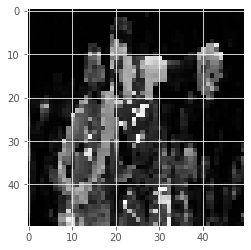

In [152]:

# =============================================================================

if REBUILD_DATA:
    lebarnVtate = LebarnVSTate()
    lebarnVtate.make_training_data()

training_data = np.load("./training_data.npy", allow_pickle=True)
print(len(training_data))


# Now we can split our training data into X and y, as well as convert it to a tensor:
X = torch.Tensor([i[0] for i in training_data]).view(-1, 50, 50)
X = X/255.0
y = torch.Tensor([i[1] for i in training_data])

# show first image of training data
plt.imshow(X[2], cmap="gray")
print(y[2])
# plt.show()


In [153]:

# =============================================================================

if torch.cuda.is_available():
    # you can continue going on here, like cuda:1 cuda:2....etc.
    device = torch.device("cuda:0")
    print("Running on the GPU")
else:
    device = torch.device("cpu")
    print("Running on the CPU")


Running on the CPU


In [154]:

# =============================================================================

# Constants
BATCH_SIZE = 100
EPOCHS = 5

# gives a dynamic model name, to just help with things getting messy over time.
MODEL_NAME = f"model-{int(time.time())}"
net = Net().to(device)
optimizer = optim.Adam(net.parameters(), lr=0.001)
loss_function = nn.MSELoss()

print(MODEL_NAME)

VAL_PCT = 0.1  # lets reserve 10% of our data for validation
val_size = int(len(X)*VAL_PCT)
print(val_size)
train_X = X[:-val_size]
train_y = y[:-val_size]

test_X = X[-val_size:]
test_y = y[-val_size:]


def fwd_pass(X, y, train=False):
    if train:
        net.zero_grad()
    outputs = net(X)
    matches = [torch.argmax(i) == torch.argmax(j) for i, j in zip(outputs, y)]
    acc = matches.count(True)/len(matches)
    loss = loss_function(outputs, y)

    if train:
        loss.backward()
        optimizer.step()

    return acc, loss


def train(net):
    BATCH_SIZE = 100
    EPOCHS = 30

    with open("model.log", "a") as f:
        for epoch in range(EPOCHS):
            for i in tqdm(range(0, len(train_X), BATCH_SIZE)):
                batch_X = train_X[i:i+BATCH_SIZE].view(-1, 1, 50, 50)
                batch_y = train_y[i:i+BATCH_SIZE]

                batch_X, batch_y = batch_X.to(device), batch_y.to(device)

                acc, loss = fwd_pass(batch_X, batch_y, train=True)

                print(
                    f"Acc: {round(float(acc),2)}  Loss: {round(float(loss),4)}")
                # f.write(f"{MODEL_NAME},{round(time.time(),3)},train,{round(float(acc),2)},{round(float(loss),4)}\n")
                # just to show the above working, and then get out:
                if i % 40 == 0:
                    val_acc, val_loss = test(size=100)
                    f.write(
                        f"{MODEL_NAME},{round(time.time(),3)},{round(float(acc),2)},{round(float(loss), 4)},{round(float(val_acc),2)},{round(float(val_loss),4)},{epoch}\n")


def test(size=32):
    X, y = test_X[:size], test_y[:size]
    val_acc, val_loss = fwd_pass(
        X.view(-1, 1, 50, 50).to(device), y.to(device))
    return val_acc, val_loss


train(net)



model-1670354069
41


 25%|██▌       | 1/4 [00:00<00:01,  2.02it/s]

Acc: 0.49  Loss: 0.2506


 50%|█████     | 2/4 [00:00<00:00,  3.12it/s]

Acc: 0.5  Loss: 0.2464
Acc: 0.64  Loss: 0.2363


100%|██████████| 4/4 [00:01<00:00,  3.86it/s]


Acc: 0.51  Loss: 0.3051


  0%|          | 0/4 [00:00<?, ?it/s]

Acc: 0.71  Loss: 0.2242


 50%|█████     | 2/4 [00:00<00:00,  4.89it/s]

Acc: 0.47  Loss: 0.2598


100%|██████████| 4/4 [00:00<00:00,  4.89it/s]


Acc: 0.44  Loss: 0.2535
Acc: 0.72  Loss: 0.2374


 25%|██▌       | 1/4 [00:00<00:00,  4.56it/s]

Acc: 0.73  Loss: 0.2321


 50%|█████     | 2/4 [00:00<00:00,  5.05it/s]

Acc: 0.64  Loss: 0.2347
Acc: 0.64  Loss: 0.2321


100%|██████████| 4/4 [00:00<00:00,  5.15it/s]


Acc: 0.51  Loss: 0.2403


  0%|          | 0/4 [00:00<?, ?it/s]

Acc: 0.68  Loss: 0.2203


 75%|███████▌  | 3/4 [00:00<00:00,  5.03it/s]

Acc: 0.67  Loss: 0.2177
Acc: 0.62  Loss: 0.2181


100%|██████████| 4/4 [00:00<00:00,  5.40it/s]


Acc: 0.61  Loss: 0.2181


 25%|██▌       | 1/4 [00:00<00:00,  5.10it/s]

Acc: 0.73  Loss: 0.1866


 50%|█████     | 2/4 [00:00<00:00,  5.42it/s]

Acc: 0.64  Loss: 0.2044
Acc: 0.62  Loss: 0.2036


100%|██████████| 4/4 [00:00<00:00,  5.61it/s]


Acc: 0.63  Loss: 0.2269


  0%|          | 0/4 [00:00<?, ?it/s]

Acc: 0.79  Loss: 0.1609


 50%|█████     | 2/4 [00:00<00:00,  4.99it/s]

Acc: 0.65  Loss: 0.2055
Acc: 0.68  Loss: 0.2078


100%|██████████| 4/4 [00:00<00:00,  5.13it/s]


Acc: 0.79  Loss: 0.1771


  0%|          | 0/4 [00:00<?, ?it/s]

Acc: 0.82  Loss: 0.1483


 50%|█████     | 2/4 [00:00<00:00,  3.93it/s]

Acc: 0.75  Loss: 0.1691
Acc: 0.71  Loss: 0.1726


100%|██████████| 4/4 [00:00<00:00,  4.61it/s]


Acc: 0.76  Loss: 0.1595


 25%|██▌       | 1/4 [00:00<00:00,  5.07it/s]

Acc: 0.88  Loss: 0.1149


 50%|█████     | 2/4 [00:00<00:00,  5.50it/s]

Acc: 0.81  Loss: 0.1539


 75%|███████▌  | 3/4 [00:00<00:00,  5.30it/s]

Acc: 0.78  Loss: 0.1577


100%|██████████| 4/4 [00:00<00:00,  5.71it/s]


Acc: 0.8  Loss: 0.1327


 25%|██▌       | 1/4 [00:00<00:00,  5.05it/s]

Acc: 0.91  Loss: 0.0868


 50%|█████     | 2/4 [00:00<00:00,  5.48it/s]

Acc: 0.85  Loss: 0.1201


 75%|███████▌  | 3/4 [00:00<00:00,  5.28it/s]

Acc: 0.8  Loss: 0.1333


100%|██████████| 4/4 [00:00<00:00,  5.68it/s]


Acc: 0.91  Loss: 0.0897


  0%|          | 0/4 [00:00<?, ?it/s]

Acc: 0.95  Loss: 0.0615


 50%|█████     | 2/4 [00:00<00:00,  4.40it/s]

Acc: 0.88  Loss: 0.0922


100%|██████████| 4/4 [00:01<00:00,  3.79it/s]

Acc: 0.84  Loss: 0.099
Acc: 0.92  Loss: 0.0715


 25%|██▌       | 1/4 [00:00<00:00,  5.04it/s]

Acc: 0.96  Loss: 0.0408


 50%|█████     | 2/4 [00:00<00:00,  5.39it/s]

Acc: 0.91  Loss: 0.0702
Acc: 0.9  Loss: 0.0738


100%|██████████| 4/4 [00:00<00:00,  5.57it/s]


Acc: 0.91  Loss: 0.0528


  0%|          | 0/4 [00:00<?, ?it/s]

Acc: 0.93  Loss: 0.0416


 50%|█████     | 2/4 [00:00<00:00,  5.03it/s]

Acc: 0.93  Loss: 0.0444
Acc: 0.93  Loss: 0.0554


100%|██████████| 4/4 [00:00<00:00,  5.24it/s]


Acc: 0.96  Loss: 0.0283


  0%|          | 0/4 [00:00<?, ?it/s]

Acc: 0.99  Loss: 0.0173


 50%|█████     | 2/4 [00:00<00:00,  5.32it/s]

Acc: 0.97  Loss: 0.0281


 75%|███████▌  | 3/4 [00:00<00:00,  5.21it/s]

Acc: 0.98  Loss: 0.0259


100%|██████████| 4/4 [00:00<00:00,  5.57it/s]


Acc: 1.0  Loss: 0.0175


 25%|██▌       | 1/4 [00:00<00:00,  4.27it/s]

Acc: 0.99  Loss: 0.0078


 50%|█████     | 2/4 [00:00<00:00,  4.17it/s]

Acc: 0.97  Loss: 0.0181


100%|██████████| 4/4 [00:00<00:00,  4.33it/s]


Acc: 0.98  Loss: 0.0147
Acc: 0.97  Loss: 0.0122


 50%|█████     | 2/4 [00:00<00:00,  5.40it/s]

Acc: 1.0  Loss: 0.0067
Acc: 1.0  Loss: 0.0099


100%|██████████| 4/4 [00:00<00:00,  5.30it/s]


Acc: 0.99  Loss: 0.0096
Acc: 0.97  Loss: 0.0098


 25%|██▌       | 1/4 [00:00<00:01,  2.94it/s]

Acc: 1.0  Loss: 0.0036


 50%|█████     | 2/4 [00:00<00:00,  3.55it/s]

Acc: 0.97  Loss: 0.0092


 75%|███████▌  | 3/4 [00:00<00:00,  3.31it/s]

Acc: 0.99  Loss: 0.0083


100%|██████████| 4/4 [00:01<00:00,  2.88it/s]


Acc: 0.97  Loss: 0.0099


 25%|██▌       | 1/4 [00:00<00:00,  3.06it/s]

Acc: 1.0  Loss: 0.0021


 50%|█████     | 2/4 [00:00<00:00,  3.88it/s]

Acc: 1.0  Loss: 0.0052


 75%|███████▌  | 3/4 [00:00<00:00,  3.86it/s]

Acc: 0.99  Loss: 0.0077


100%|██████████| 4/4 [00:00<00:00,  4.10it/s]


Acc: 0.97  Loss: 0.0121


 25%|██▌       | 1/4 [00:00<00:00,  3.65it/s]

Acc: 1.0  Loss: 0.0017


 50%|█████     | 2/4 [00:00<00:00,  3.61it/s]

Acc: 1.0  Loss: 0.0046


 75%|███████▌  | 3/4 [00:01<00:00,  2.77it/s]

Acc: 0.99  Loss: 0.007


100%|██████████| 4/4 [00:01<00:00,  3.14it/s]


Acc: 0.97  Loss: 0.0112


 25%|██▌       | 1/4 [00:00<00:00,  3.50it/s]

Acc: 1.0  Loss: 0.0017


 50%|█████     | 2/4 [00:00<00:00,  4.31it/s]

Acc: 1.0  Loss: 0.005
Acc: 0.99  Loss: 0.007


100%|██████████| 4/4 [00:00<00:00,  4.73it/s]


Acc: 0.97  Loss: 0.0106


 25%|██▌       | 1/4 [00:00<00:01,  2.67it/s]

Acc: 1.0  Loss: 0.0018


 75%|███████▌  | 3/4 [00:00<00:00,  4.15it/s]

Acc: 1.0  Loss: 0.0053
Acc: 0.99  Loss: 0.0069


100%|██████████| 4/4 [00:00<00:00,  4.30it/s]


Acc: 0.97  Loss: 0.0113


  0%|          | 0/4 [00:00<?, ?it/s]

Acc: 1.0  Loss: 0.0015


 50%|█████     | 2/4 [00:00<00:00,  4.62it/s]

Acc: 1.0  Loss: 0.0048


100%|██████████| 4/4 [00:00<00:00,  4.31it/s]


Acc: 0.99  Loss: 0.0068
Acc: 0.97  Loss: 0.0117


 50%|█████     | 2/4 [00:00<00:00,  5.44it/s]

Acc: 1.0  Loss: 0.0014
Acc: 1.0  Loss: 0.0043


100%|██████████| 4/4 [00:00<00:00,  5.68it/s]


Acc: 0.99  Loss: 0.0068
Acc: 0.97  Loss: 0.0121


 50%|█████     | 2/4 [00:00<00:00,  5.47it/s]

Acc: 1.0  Loss: 0.0013
Acc: 1.0  Loss: 0.0043


100%|██████████| 4/4 [00:00<00:00,  5.68it/s]


Acc: 0.99  Loss: 0.0068
Acc: 0.97  Loss: 0.0116


 50%|█████     | 2/4 [00:00<00:00,  5.50it/s]

Acc: 1.0  Loss: 0.0014
Acc: 1.0  Loss: 0.0048


100%|██████████| 4/4 [00:00<00:00,  5.67it/s]


Acc: 0.99  Loss: 0.0068
Acc: 0.97  Loss: 0.011


 25%|██▌       | 1/4 [00:00<00:00,  5.03it/s]

Acc: 1.0  Loss: 0.0015


 75%|███████▌  | 3/4 [00:00<00:00,  5.22it/s]

Acc: 1.0  Loss: 0.005
Acc: 0.99  Loss: 0.0068


100%|██████████| 4/4 [00:00<00:00,  5.62it/s]


Acc: 0.97  Loss: 0.0109


 25%|██▌       | 1/4 [00:00<00:00,  5.09it/s]

Acc: 1.0  Loss: 0.0015
Acc: 1.0  Loss: 0.0048

 75%|███████▌  | 3/4 [00:00<00:00,  5.26it/s]


Acc: 0.99  Loss: 0.0068


100%|██████████| 4/4 [00:00<00:00,  5.66it/s]


Acc: 0.97  Loss: 0.0111


  0%|          | 0/4 [00:00<?, ?it/s]

Acc: 1.0  Loss: 0.0014


 50%|█████     | 2/4 [00:00<00:00,  5.46it/s]

Acc: 1.0  Loss: 0.0045


 75%|███████▌  | 3/4 [00:00<00:00,  5.27it/s]

Acc: 0.99  Loss: 0.0067


100%|██████████| 4/4 [00:00<00:00,  5.67it/s]


Acc: 0.97  Loss: 0.0113


  0%|          | 0/4 [00:00<?, ?it/s]

Acc: 1.0  Loss: 0.0014


 50%|█████     | 2/4 [00:00<00:00,  5.44it/s]

Acc: 1.0  Loss: 0.0043


 75%|███████▌  | 3/4 [00:00<00:00,  5.25it/s]

Acc: 0.99  Loss: 0.0068


100%|██████████| 4/4 [00:00<00:00,  5.65it/s]


Acc: 0.97  Loss: 0.0112


 25%|██▌       | 1/4 [00:00<00:00,  5.07it/s]

Acc: 1.0  Loss: 0.0014


 50%|█████     | 2/4 [00:00<00:00,  5.46it/s]

Acc: 1.0  Loss: 0.0044


 75%|███████▌  | 3/4 [00:00<00:00,  5.25it/s]

Acc: 0.99  Loss: 0.0068


100%|██████████| 4/4 [00:00<00:00,  5.66it/s]


Acc: 0.97  Loss: 0.0109


 25%|██▌       | 1/4 [00:00<00:00,  5.11it/s]

Acc: 1.0  Loss: 0.0015


 50%|█████     | 2/4 [00:00<00:00,  5.47it/s]

Acc: 1.0  Loss: 0.0045


 75%|███████▌  | 3/4 [00:00<00:00,  5.29it/s]

Acc: 0.99  Loss: 0.0068


100%|██████████| 4/4 [00:00<00:00,  5.71it/s]

Acc: 0.97  Loss: 0.0108


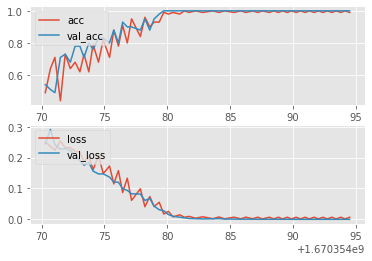

In [155]:

# =============================================================================


style.use("ggplot")

# grab whichever model name you want here. We could also just reference the MODEL_NAME if you're in a notebook still.
model_name = MODEL_NAME  # "model-1669602423"


def create_acc_loss_graph(model_name):
    contents = open("model.log", "r").read().split("\n")

    times = []
    accuracies = []
    losses = []

    val_accs = []
    val_losses = []

    for c in contents:
        if model_name in c:
            name, timestamp, acc, loss, val_acc, val_loss, epoch = c.split(",")

            times.append(float(timestamp))
            accuracies.append(float(acc))
            losses.append(float(loss))

            val_accs.append(float(val_acc))
            val_losses.append(float(val_loss))

    fig = plt.figure()

    ax1 = plt.subplot2grid((2, 1), (0, 0))
    ax2 = plt.subplot2grid((2, 1), (1, 0), sharex=ax1)

    ax1.plot(times, accuracies, label="acc")
    ax1.plot(times, val_accs, label="val_acc")
    ax1.legend(loc=2)
    ax2.plot(times, losses, label="loss")
    ax2.plot(times, val_losses, label="val_loss")
    ax2.legend(loc=2)
    plt.show()


create_acc_loss_graph(model_name)


1
James Confidence and Loss: 1.0, 0.9908773303031921


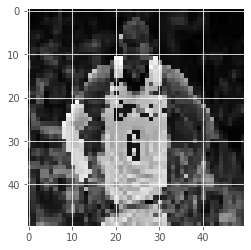

In [157]:
# After Network Has been trained
# Run User Inputed Images
IMG_SIZE = 50
test = []

img = cv2.imread('/Users/mali/dev/deep-learning-pytorch/src/testing/test.jpg', cv2.IMREAD_GRAYSCALE)
img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))

# do something like print(np.eye(2)[1]), just makes one_hot
test.append([np.array(img), np.eye(2)[1]])

#self.training_data.append([np.array(img), np.eye(2)[self.LABELS[label]]])
lebarnVtate = LebarnVSTate()
print(lebarnVtate.LABELS[lebarnVtate.TATUM])
X = torch.Tensor(test[0][0]).view(-1, 50, 50)
# pixel values (we want a num between 0-1)
X = X/255.0
y = torch.Tensor(test[0][1])
plt.imshow(X[0], cmap="gray")
acc, loss = fwd_pass(X, y)

print(f"James Confidence and Loss: {acc}, {loss}")